# Model recovery attack: `news-popularity`

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mra
from mra import *

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_csv('../datasets/news-popularity.csv').sample(frac=1)
df = df.drop(columns=["url"])
xy = df.to_numpy()
x = xy[:,1:-1] # remove the first feature as it is not predictive
y = xy[:,-1]
# Normalize by feature to [0,1]
min_values = pd.DataFrame(x).describe().transpose()['min'].to_numpy()
max_values = pd.DataFrame(x).describe().transpose()['max'].to_numpy()
x = (x-min_values)/(max_values-min_values)
y = np.array([float(i >= 1500) for i in y]).reshape((len(x), 1))
train_ds = make_dataset(x, y, lambda t: t)

mra = mra(train_ds)

2022-02-16 22:44:08.621100: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-16 22:44:08.621149: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: xgpg2
2022-02-16 22:44:08.621155: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: xgpg2
2022-02-16 22:44:08.621252: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-02-16 22:44:08.621271: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-02-16 22:44:08.621276: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-02-16 22:44:08.621672: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in per

In [13]:
x[0]

array([5.71428571e-01, 5.48737314e-02, 8.36029449e-04, 9.59692895e-04,
       1.15653577e-03, 2.63157895e-02, 1.72413793e-02, 3.12500000e-02,
       0.00000000e+00, 6.30864530e-01, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.68632708e-03, 8.88808836e-03,
       0.00000000e+00, 1.00000000e+00, 2.39214989e-01, 2.76698667e-04,
       4.83635389e-02, 9.98560386e-02, 8.06355982e-03, 8.06355982e-03,
       8.06355982e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 9.92345654e-01, 2.16098369e-02, 2.17477144e-02,
       2.16115428e-02, 2.16351217e-02, 5.52094017e-01, 3.86927040e-01,
       2.21294539e-01, 1.16288331e-01, 6.15384615e-01, 3.84615385e-01,
       3.23392857e-01, 5.00000000e-02, 8.00000000e-01, 7.41944444e-01,
       5.00000000e-01, 9.50000000e-01, 0.00000000e+00, 5.00000000e-01,
      

In [3]:
def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    # x = tf.keras.layers.BatchNormalization()(xin)
    x = tf.keras.layers.Dense(256, activation="relu")(xin)
    output = tf.keras.layers.Dense(256, activation="relu")(x)
    return tf.keras.Model(xin, output)

def make_g(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(256, activation="relu")(xin)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(xin, output)

In [4]:
log_train = mra.train(
    make_f,
    make_g,
    loss_fn=tf.keras.losses.binary_crossentropy,
    batch_size=32,
    epoch=5,
    lr=0.001,
    verbose=True, log_every=1000)

Iteration 0001: Training loss: 0.6870
Iteration 1001: Training loss: 0.6724
Iteration 2001: Training loss: 0.6450
Iteration 3001: Training loss: 0.5686
Iteration 4001: Training loss: 0.6170
Iteration 5001: Training loss: 0.6539
Iteration 6001: Training loss: 0.6146


In [18]:
def make_generator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(1024, activation=act)(xin)
    x = tf.keras.layers.Dense(512, activation=act)(x)
    x = tf.keras.layers.Dense(256, activation=act)(x)
    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = tf.keras.layers.Dense(58, activation="sigmoid")(x)
    return tf.keras.Model(xin, x)

In [19]:
log_attack = mra.attack(
    attack_iter=100,
    make_generator=make_generator,
    input_noise="normal",
    input_z=True,
    model_leak=True,
    lr_x=0.001,
    lr_f=0.0001,
    epoch=200,
    iter_x=50,
    iter_f=1,
    verbose=True, log_every=1)

Iteration 0001: RG-uniform: 0.2724, RG-normal: 0.2464, reconstruction validation: 0.2061


KeyboardInterrupt: 

In [ ]:
np.savetxt('./log/news-2.csv', log_attack, delimiter=',')

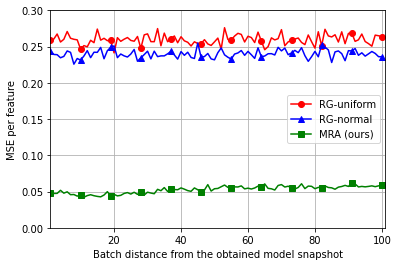

In [ ]:
plt.xlim([1,101])
plt.ylim([0,0.3])
plt.grid()
plt.ylabel('MSE per feature')
plt.xlabel('Batch distance from the obtained model snapshot')
ran = [i+1 for i in range(100)]
plt.plot(ran, log_attack[:,0], 'ro-', ran, log_attack[:,1], 'b^-', ran, log_attack[:,2], 'gs-', markevery=np.arange(0, 101, 9))
plt.legend(['RG-uniform', 'RG-normal', 'MRA (ours)'], loc='center right')
plt.savefig("fig/news-2.pdf", bbox_inches='tight')